# NQ Filtering
    
## goal

the goal of filtering users from a partner when they receive a high number of nqs is to stop users from taking surveys with partners

## data
    - add histogram of nq %
    - add filtered user count
    - add filtered click count
    - add % of filtered users that were hellbanned
    - add % of filtered clicks by partner (pie chart)
    - add % of filtered users by partner (pie chart)
    - add histogram for number of partners blocked per user
    - add collection of partner status codes
    - add partner term codes to dataset
    
## optimizations:
    - change dicts to lists and timestamps to seconds int (will make run faster with cython and less memory)
    - only pull data for users with abnormal nq rates (might not show full effects) (faster cus less data to train on)
    
    
    
    
## training process:
    - pull click data for all users (1 year period)
    - pull data for abnormal nq rate users (1 year period)
    - run genetic algorithm optimization on abnormal click user data
    - test optimal parameters on full click data set
    




In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pymoo
from utils import generate_data

from datetime import datetime, timedelta


DB_DATETIME = '%Y-%m-%d %H:%M:%S'

data_map = {
    'result': 0,
    'cpi': 1,
    'click_timestamp': 2,
    'term_timestamp': 3,
    'status_code_1': 4,
    'status_code_2': 5
}

In [2]:
data = generate_data(path='./data/partner_users_dataset.csv', user_pct = 1.0)

(34580407, 8)
(589562,)


100%|██████████| 589562/589562 [01:26<00:00, 6828.25it/s]  


In [5]:
del data

In [3]:
import sys
print('file size:', round(sys.getsizeof(data)/(1024 * 1024 * 1024), 2), 'GB')

file size: 0.02 GB


In [4]:
print(list(data.keys())[0])
print(data[list(data.keys())[0]])

(4, 17)
[[2, 0.71, 1620577007, 1620578038.0, 3, 10], [2, 0.53, 1620780818, 1620781076.0, 3, 10], [2, 2.1, 1620781134, 1620781547.0, 3, 10], [8, 0.32, 1620781997, 1620782017.0, 3, 30], [0, 5.6, 1620783826, 0.0, 0, 0], [14, 0.88, 1620793322, 1620793355.0, 3, 40], [2, 1.75, 1620794201, 1620794663.0, 3, 10], [2, 1.58, 1620794782, 1620796521.0, 3, 10], [2, 1.75, 1620794791, 1620794791.0, 3, 10], [2, 1.58, 1620796640, 1620796640.0, 3, 10]]


In [3]:
%load_ext cython

In [18]:
%%cython -a
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
DB_DATETIME = '%Y-%m-%d %H:%M:%S'
def cython_simulate_filtering(data, x=[7, 7, 5, 20, 8], out={}):
    
    data_map = {
        'result': 0,
        'cpi': 1,
        'click_timestamp': 2,
        'term_timestamp': 3,
        'status_code_1': 4,
        'status_code_2': 5
    }
    
    #cdef int total_completes = total_revenue = total_clicks = total_terms = total_nqs = 0
    
    # define simulation a params
    cdef int days_to_look = x[0]
    cdef int days_to_block = x[1]
    cdef int min_click_to_block = x[2]
    cdef int min_nq_pct_to_block = x[3]
    cdef int min_nq_to_block = x[4]
    
    # define metrics variables
    cdef int total_completes = 0
    cdef float total_revenue = 0
    cdef int total_clicks = 0
    cdef int total_terms = 0
    cdef int total_nqs = 0
    cdef float max_revenue = 0
    cdef int max_nqs = 0
    
    # predefine variables
    cdef int result = 0
    cdef int click_time = 0
    cdef int term_time = 0
    cdef float cpi = 0
    
    # window to look at for nqs
    cdef float time_window = days_to_look*24*60*60
    
    # window to block user
    cdef float block_window = days_to_block*24*60*60
    
    cdef int block_time = 0
    cdef bint is_filtered = False
    
    for group_user in list(data.keys()):    
        
        block_time = 0
        is_filtered = False
        click_cache = {}
        
        for click in data[group_user]:
            
            result = click[data_map['result']]
            click_time = click[data_map['click_timestamp']]
            term_time = click[data_map['term_timestamp']]
            cpi = click[data_map['cpi']]
            
            if result == 2:
                max_revenue += cpi
                
            if (result == 3 or result == 8 or result == 14) and term_time-click_time < 60:
                max_nqs += 1
            
            if is_filtered:
                
                if block_time + block_window < click_time:
                    block_time = 0
                    is_filtered = False
                    
                else:
                    continue
                    
            total_clicks += 1
            
            # record metrics
            if result == 2:
                total_completes += 1
                total_revenue += cpi
                
            if term_time != 0:
                total_terms += 1
                
            if (result == 3 or result == 8 or result == 14) and term_time-click_time < 60:
                total_nqs += 1
                click_cache[click_time] = 1
                
            else:
                click_cache[click_time] = 0
              
            
            # remove clicks from cache when beyond time window
            to_delete = []
            for time in click_cache.keys():
                if click_time - time_window > time:
                    to_delete.append(time)
            
            for time in to_delete:
                del click_cache[time]

            nq_count = sum(click_cache.values())
            click_count = len(click_cache)
            nq_percent = round(100*nq_count/click_count)
            
            if nq_percent > min_nq_pct_to_block and click_count > min_click_to_block and nq_count > min_nq_to_block:
                is_filtered = True
                block_time = click_time
    
    '''
    print('total revenue: ${}'.format(round(total_revenue, 2)))
    print('total completes: {}'.format(total_completes))
    print('total clicks: {}'.format(total_clicks))
    print('epc: {}'.format(round(total_completes/total_clicks, 2)))
    print('total nqs: {}'.format(total_nqs))
    print('nq rate: {}%'.format(round(100*total_nqs/total_clicks, 2)))
    '''
    
    ir = round(total_completes/total_clicks, 4)
    nq_rate = round(total_nqs/max_nqs, 4)
    pct_revenue = round(total_revenue/max_revenue, 4)
    
    #out["F"] = [total_revenue, ir, total_nqs]
    #out["G"] = [g1, g2]
    
    return pct_revenue, ir, nq_rate

In [5]:
%timeit cython_simulate_filtering(data, x=[11.62392965, 74.72943058, 42.75687872, 31.90416561, 10])

3.52 s ± 65.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(4, 70761)


In [5]:
def simulate_filtering(data, x=[7, 7, 5, 20, 8], out={}):
    
    data_map = {
        'result': 0,
        'cpi': 1,
        'click_timestamp': 2,
        'term_timestamp': 3,
        'status_code_1': 4,
        'status_code_2': 5
    }
    
    #cdef int total_completes = total_revenue = total_clicks = total_terms = total_nqs = 0
    
    # define simulation a params
    days_to_look = x[0]
    days_to_block = x[1]
    min_click_to_block = x[2]
    min_nq_pct_to_block = x[3]
    min_nq_to_block = x[4]
    
    # define metrics variables
    total_completes = 0
    total_revenue = 0
    total_clicks = 0
    total_terms = 0
    total_nqs = 0
    max_revenue = 0
    max_nqs = 0
    
    # predefine variables
    result = 0
    click_time = 0
    term_time = 0
    cpi = 0
    
    # window to look at for nqs
    time_window = days_to_look*24*60*60
    
    # window to block user
    block_window = days_to_block*24*60*60
    
    term_counts = {}
    user_filters = {}
    
    for group_user in tqdm(list(data.keys())):    
        
        block_time = None
        is_filtered = False
        click_cache = {}
        
        for click in data[group_user]:
            
            result = click[data_map['result']]
            click_time = click[data_map['click_timestamp']]
            term_time = click[data_map['term_timestamp']]
            cpi = click[data_map['cpi']]
            
            status_code_1 = click[data_map['status_code_1']]
            status_code_2 = click[data_map['status_code_2']]
            
            if result == 2:
                max_revenue += cpi
                
            if result == 3:
                max_nqs += 1
            
            if is_filtered:
                
                if block_time + block_window < click_time:
                    is_filtered = False
                    block_time = None
                    
                else:
                    
                    if term_time != 0:
                        
                        if group_user[1] not in user_filters:
                            user_filters[group_user[1]] = 0
                        
                        user_filters[group_user[1]] += 1
                        
                        # use group id as key
                        if group_user[0] not in term_counts:
                            term_counts[group_user[0]] = {}

                        if status_code_1 not in term_counts[group_user[0]]:
                             term_counts[group_user[0]][status_code_1] = 0

                        term_counts[group_user[0]][status_code_1] += 1
                    
                    continue
                    
            total_clicks += 1
            
            # record metrics
            if result == 2:
                total_completes += 1
                total_revenue += cpi
                
            if  term_time != 0:
                total_terms += 1
                
            if result == 3 and term_time-click_time < 60:
                total_nqs += 1
                click_cache[click_time] = 1
                
            else:
                click_cache[click_time] = 0
                
               
            # rules not applied when no term exists
            if result == 0 or term_time == 0:
                continue
            
            # remove clicks from cache when beyond time window
            to_delete = []
            for time in click_cache.keys():
                #print(term_time, time_window, term_time - time_window, time)
                if click_time - time_window > time:
                    to_delete.append(time)
            
            for time in to_delete:
                del click_cache[time]

            nq_count = sum(click_cache.values())
            click_count = len(click_cache)
            
            nq_percent = round(100*nq_count/click_count)
            
            if nq_percent > min_nq_pct_to_block and click_count > min_click_to_block and nq_count > min_nq_to_block:
                is_filtered = True
                block_time = click_time
            
            
    print('total revenue: ${}'.format(round(total_revenue, 2)))
    print('total completes: {}'.format(total_completes))
    print('total clicks: {}'.format(total_clicks))
    print('epc: {}'.format(round(total_completes/total_clicks, 2)))
    print('total nqs: {}'.format(total_nqs))
    print('nq rate: {}%'.format(round(100*total_nqs/total_clicks, 2)))
    
    ir = round(total_completes/total_clicks, 4)
    nq_rate = round(total_nqs/max_nqs, 4)
    pct_revenue = round(total_revenue/max_revenue, 4)
    
    #out["F"] = [total_revenue, ir, total_nqs]
    #out["G"] = [g1, g2]
    
    print(term_counts)
    
    print(dict(sorted(user_filters.items(), key=lambda item: item[1])))
    
    return pct_revenue, ir, nq_rate

In [ ]:
%timeit simulate_filtering(data, x=[11.62392965, 74.72943058, 42.75687872, 31.90416561, 1])

In [72]:
simulate_filtering(data, x=[4.85422828481118, 16.25720348358850, 42.69533708486410, 5.1756446622618300, 24.067653660928000])

100%|██████████| 5113/5113 [00:02<00:00, 1972.29it/s]

total revenue: $232157.47
total completes: 165652
total clicks: 781778
epc: 0.21
total nqs: 83988
nq rate: 10.74%
{4: {23: 3020, 3: 59170, 0: 6358, 24: 2538, 40: 772, 230: 581, 42: 343, 41: 30, 36: 735, 21: 91, 133: 17, 138: 175, 139: 37, 30: 91, 32: 525, 238: 8209, 1: 11, 131: 28, 126: 24, -1: 1, 35: 1}, 14: {0: 2287}, 18: {17: 95, 30: 133, 20: 191, 21: 390, 18: 572, 24: 2, 37: 8, 13: 12, 45: 10, 12: 3, 32: 19, 35: 9, 29: 2, 23: 5, 15: 6, 26: 41, 22: 1, 0: 1, 69: 102, 31: 2, 42: 2, 70: 2, 46: 1}, 60: {7: 32, 5: 76, 30: 36, 26: 6, 6: 13, 28: 81, 11: 2}, 64: {0: 10136, 10: 49, 4: 17, 1: 9, 3: 28, 2: 7, 6: 1}}
{2542889: 90, 621072: 102, 649818: 122, 4482823: 124, 3672313: 126, 12451801: 126, 1022530: 132, 11334145: 135, 882604: 150, 14484825: 164, 14176441: 168, 7592028: 175, 2495514: 187, 6422203: 210, 8289828: 210, 8765973: 213, 7138836: 214, 2341621: 253, 1963323: 256, 13526397: 303, 8666057: 332, 2105133: 339, 1415132: 369, 10675305: 382, 1518146: 438, 7066500: 475, 12216921: 719, 13

(0.9078, 0.2119, 0.3215)

In [43]:
cython_simulate_filtering(data, x=[15.616012741995426,	29.795177260588197,	26.714730521966565,	39.302098646755475,	83.36967306381558])

total revenue: $93908.15
total completes: 71925
total clicks: 344981
epc: 0.21
total nqs: 96991
nq rate: 28.11%


(0.9545, 0.2085, 0.8983)

In [6]:
from pymoo.core.problem import ElementwiseProblem


# define problem
class FilteringNQs(ElementwiseProblem):
    
    '''
    days_to_look = x[0]
    days_to_block = x[1]
    min_click_to_block = x[2]
    min_nq_pct_to_block = x[3]
    '''
    
    
    def __init__(self, **kwargs):
        super().__init__(n_var=5,
                         n_obj=3,
                         n_constr=0,
                         xl=np.array([1, 1, 1, 1, 1]), # lower bound for params
                         xu=np.array([30, 90, 100, 100, 100]), # upper bound for params
                        )
        '''
        if data == None:
            self.data = generate_data(path='./data/nqs-2021-10-03.csv', user_pct=0.5)
        
        else:
            self.data = data\
        '''

    def _evaluate(self, x, out, *args, **kwargs):
        
        pct_revenue, ir, nq_rate = cython_simulate_filtering(data, x=x)
        
        f1 = -1 * pct_revenue
        f2 = -1 * ir
        f3 = nq_rate
        
        out["F"] = [f1, f2, f3]
        #out["G"] = [g1, g2]




In [19]:
from pymoo.core.problem import starmap_parallelized_eval
from multiprocessing.pool import ThreadPool

# the number of threads to be used
n_threads = 5

# initialize the pool
pool = ThreadPool(n_threads)

# define the problem by passing the starmap interface of the thread pool
problem = FilteringNQs(runner=pool.starmap, func_eval=starmap_parallelized_eval)

In [20]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=80,
    n_offsprings=20,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

In [21]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 10)

In [25]:
from pymoo.optimize import minimize
from time import time

t = time()
res = minimize(problem,
               algorithm,
               termination,
               seed=2,
               save_history=True,
               verbose=True)


print('time taken:', time()-t)

X = res.X
F = res.F

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      80 |      49 |            - |            -
    2 |     100 |      53 |  0.009141275 |            f
    3 |     120 |      63 |  0.007931874 |            f
    4 |     140 |      76 |  0.101912568 |        ideal
    5 |     160 |      80 |  0.006561479 |            f
    6 |     180 |      80 |  0.003221505 |            f
    7 |     200 |      80 |  0.005714857 |            f
    8 |     220 |      80 |  0.063583815 |        ideal
    9 |     240 |      80 |  0.010360547 |        nadir
   10 |     260 |      80 |  0.004126195 |            f
time taken: 869.7162418365479


In [16]:
df = pd.DataFrame(
    data=np.concatenate((F, X), axis=1),
    columns=[
        'Negative Rev',
        'Neg IR',
        'NQ Rate',
        'days_to_look',
        'days_to_block',
        'min_click_to_block',
        'min_nq_pct_to_block',
        'min_nq_to_block',
    ]
)
df.to_csv('results.csv')

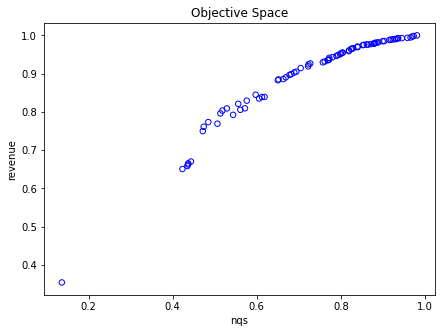

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 2], -1*F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("nqs")
plt.ylabel("revenue")
plt.show()

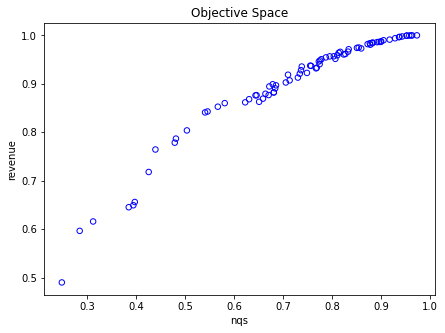

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 2], -1*F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("nqs")
plt.ylabel("revenue")
plt.show()

In [6]:
import multiprocessing 
 
print(multiprocessing.cpu_count()) 

12
